# Test 10-5-3 Network

In [202]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from IPython.display import display
from ipywidgets import FloatProgress

%load_ext autoreload
%autoreload 1
%aimport PCNetwork
%aimport PCLayer
%aimport PCConnection

dtype = torch.float32
if torch.cuda.is_available():
    device = torch.device("cuda:0") # Uncomment this to run on GPU
else:
    device = torch.device("cpu")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Dataset

In [63]:
# This creates a dataset

n_classes = 3
hidden_dim = 5
sensory_dim = 10

seed = 2950
torch.manual_seed(seed)
np.random.seed(seed)
B = torch.eye(n_classes)
X = 3.*(torch.rand((sensory_dim, n_classes)) - 0.5)
A = X.T
print('Input vectors')
print(A)
print('Target vectors')
print(B)

Input vectors
tensor([[ 0.3232, -0.9563,  0.5234,  1.4845, -0.3955,  0.9563, -0.8818, -1.4115,
          1.3157,  0.8915],
        [ 1.2468,  0.5938,  0.8025, -1.0985, -1.3189, -0.9960,  0.8459, -0.2334,
          0.5250,  1.1660],
        [-0.8239, -1.1012,  0.0545,  0.2905, -0.4973,  1.3367, -1.4346,  0.9836,
         -0.9238, -0.5371]])
Target vectors
tensor([[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.]])


In [64]:
class SimpleDataset(Dataset):
    def __init__(self, A, B, n=300, noise=0.1):
        self.samples = []
        n_classes = len(A)
        for i in range(n):
            r = np.random.randint(n_classes)
            sample = [A[r]+noise*torch.randn_like(A[r]), B[r]]
            self.samples.append(sample)
        
    def __getitem__(self, idx):
        return self.samples[idx]
        
    def __len__(self):
        return len(self.samples)
    
    def Inputs(self):
        x = []
        for s in self.samples:
            x.append(s[0])
        return torch.stack(x)
    
    def Targets(self):
        t = []
        for s in self.samples:
            t.append(s[1])
        return torch.stack(t)
    
    def Plot(self, labels=[], idx=(1,2), equal=True):
        X = self.Inputs()
        if len(labels)==0:
            labels = self.Targets()
        colour_options = ['y', 'r', 'g', 'b', 'k']
        cidx = torch.argmax(labels, axis=1)
        colours = [colour_options[k] for k in cidx]
        plt.scatter(X[:,idx[0]], X[:,idx[1]], color=colours, marker='.')

        if equal:
            plt.axis('equal');

In [65]:
blah = SimpleDataset(A, B, n=300, noise=0.1)

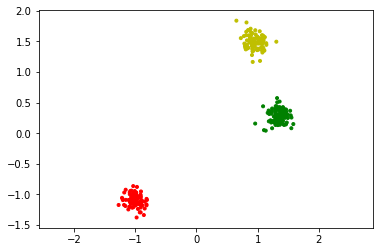

In [66]:
blah.Plot(idx=(5,3))

# Create Network

In [245]:
net = PCNetwork.PCNetwork()
net.AddLayer(PCLayer.PCLayer(n=10))  # input
net.AddLayer(PCLayer.PCLayer(n=5))   # e1
net.AddLayer(PCLayer.PCLayer(n=5))   # v1
net.AddLayer(PCLayer.PCLayer(n=3))   # e2
net.AddLayer(PCLayer.PCLayer(n=3))   # v2

af = 'tanh'
sym = True
net.Connect(v_idx=0, e_idx=1, type='general', sym=sym, act_text='identity')
net.Connect(v_idx=2, e_idx=1, type='1to1')
net.Connect(v_idx=2, e_idx=3, type='general', sym=sym, act_text=af)
net.Connect(v_idx=4, e_idx=3, type='1to1')

net.SetTau(0.05)

# Training

In [246]:
simple_ds = SimpleDataset(A, B, n=200, noise=0.0)
dl = DataLoader(simple_ds, batch_size=25, shuffle=True)
hold = 4.

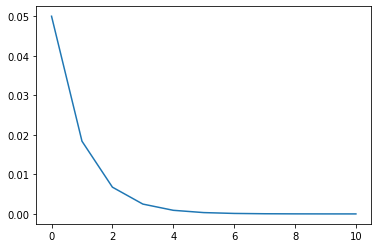

In [247]:
lambda_M = lambda t: 0.05*np.exp(-t)
tt = np.linspace(0, 10, 11)
plt.plot(tt, lambda_M(tt));

In [248]:
net.dyn_decay = (lambda t: 0.)
for k in range(5):
    net.SetWeightDecay(lambda_M(k))
    net.Learn(dl, T=4., epochs=1)

Epoch: 0
Epoch: 0
Epoch: 0
Epoch: 0
Epoch: 0


# Classification

In [249]:
net.Reset()
net.lyr[-1].Probe(True)
net.Predict(A, T=2.)

tensor([[ 9.9872e-01, -3.5543e-05,  7.8670e-05],
        [-8.0190e-05,  9.9832e-01, -7.6230e-04],
        [ 3.9340e-05, -9.3126e-04,  9.9776e-01]])

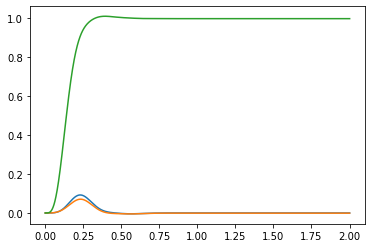

In [250]:
net.lyr[-1].Plot(net.t_history, idx=2);

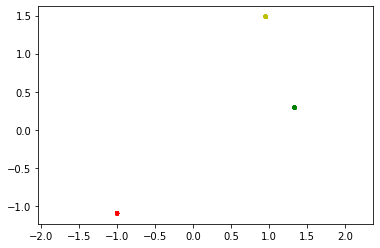

In [251]:
sidx = (5,3)
simple_ds.Plot(labels=net.Predict(simple_ds.Inputs(), T=2.), idx=sidx)

# Generation

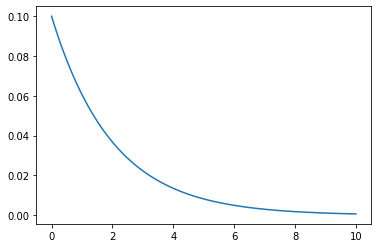

In [252]:
def lambda_x(t):
    return 0.1*torch.exp(-t/2.)
tt = torch.linspace(0, 10, 100)
plt.plot(tt, lambda_x(tt));

In [253]:
net.Reset(random=1.)
#net.SetActivityDecay(0.1)
net.dyn_decay = lambda_x
net.lyr[0].Probe(True)
z = net.Generate(simple_ds.Targets(), T=20.)

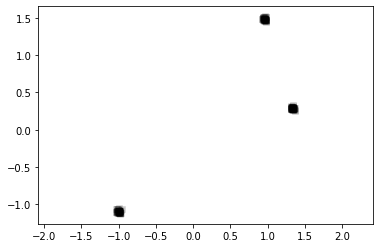

In [254]:
simple_ds.Plot(idx=sidx)
plt.plot(np.array(z[:,sidx[0]]), np.array(z[:,sidx[1]]), 's', color=[0,0,0,0.1]);

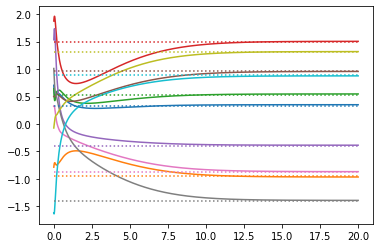

In [255]:
sampnum = 4
colours = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9'];
net.lyr[0].Plot(net.t_history, idx=sampnum)
for k,a in enumerate(simple_ds.Inputs()[sampnum]):
    plt.plot([net.t_history[0],net.t_history[-1]], [a,a], ':', color=colours[k]);